# Fix the method

The goal of this notebook is to analyze the iterative method and see that it makes sence. 


## Are the equations correct? 

By the equations I mean the 2 correction terms:

$$
        V_r = \hat{V_r}+  \frac{V_z \mu \cdot( \vec{R_0} \times \hat{e_z}) + DV_z\mu \cdot(\hat{n} \times \hat{e_z})}{\mu \cdot (\vec{R_0} \times \hat{n}) }
$$

and most importantly the distance:

$$
            D = \frac{ V_z \hat{n} \cdot ( \vec{R_0} \times \hat{e_z}) )  - \hat{n} \cdot ( \vec{R_0 \times} \vec{V_0})}{\hat{n} \cdot(\vec{R_0} \times \vec{\mu})} = \hat{D_I} + \frac{ V_z \hat{n} \cdot ( \vec{R_0} \times \hat{e_z}) ) }{\hat{n} \cdot(\vec{R_0} \times \vec{\mu})}

$$

We can test this with simulated ejections, lets try it with speedystar objects

In [35]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')

# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.correction_non_radial.iterative_correction import compute_R0xez
from scripts.correction_non_radial.iterative_correction import compute_ez
from scripts.correction_non_radial.iterative_correction import compute_R0_V0_SI
from scripts.correction_non_radial.iterative_correction import getdist_corrected
#from scripts.catalog_preparation.prepare_gaia import prepare_speedystar

In [65]:
# load some data to test
from astropy.table import Table


# lets test with some speedystar data
data = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long.fits')

In [77]:
data = data[data['v0']> 1500]

In [78]:
data

r0,phi0,theta0,v0,phiv0,thetav0,m,tage,tflight,sep,P,q,mem,met,stage,stagebefore,Rad,T_eff,Lum,vx,vy,vz,x,y,z,ra,dec,dist,par,pmra,pmdec,vlos,Lz,b,l,pmb,pml,Vesc,GCdist,GCv,thetaf,phif,Av,Bessell_V,Bessell_I,Gaia_GRVS,Gaia_G,Gaia_BP,Gaia_RP,e_par,e_pmra,e_pmdec,e_vlos,ra_clean,dec_clean,pmra_clean,pmdec_clean,radial_velocity
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mas / yr,mas / yr,km / s
float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.0,2.756798064142757,2.4151080972265357,4077.458123851052,2.756798064142757,2.4151080972265357,0.5812422014970259,2570.193209766919,47.35469596803641,2.8580605479643504,0.46097008858956945,0.650920348068256,2.0,0.0,0.0,1.0,0.5410165916048679,4017.7043456402453,0.06871138532308671,-2458.7530364171853,995.7529447877538,-2976.7667761360663,-119.3250015874385,48.324585656895785,-144.4789749163644,323.6482130544891,-27.415682095842417,198.56260110864747,0.005036195106312241,0.15868655671886495,-0.20025913343086915,3926.890671217243,-4.0248796586528604e-10,-46.557155230135145,20.727743761840937,-0.19542055633339575,-0.1646084747761132,281.534940305183,193.51458801763837,3987.2460245953876,2.4137405997439934,2.756798064142758,0.09682020038366318,30.16579071176148,28.55201374506774,28.249072772795493,29.601627614458394,30.40959991103885,28.721600824058665,2842.508997811411,1648.6552187306183,1421.2544989057055,--,33.757649866065556,7.218777339375718,0.31454541559348925,-0.11927060771101118,3935.5854041703983
3.0,2.9732296241447904,0.010538986091825154,3036.9800450812504,2.9732296241447904,0.010538986091825154,0.6034956164187659,3714.9626483298807,30.62071857043448,1.9694851504513697,0.33894529051934436,0.47846630763109654,1.0,0.0,0.0,0.0,0.5653348256995598,4090.4027350024644,0.08060674742450719,-30.464729186267586,5.1781536434143725,2921.898395810067,-0.9582034258919652,0.1628678374449882,91.9237267755142,197.90390977292793,24.178247201165203,92.3386370077968,0.01082970284600977,-0.7975010837513407,-0.08766281848808877,2902.373468923186,3.709327991667134e-15,84.58064862587607,1.0710367555850835,0.6117157944428849,-0.5191305569497413,349.2750059189082,91.92886502093481,2922.0617975048017,0.010573006361840423,2.97322962414479,0.04274179865157125,28.202933109086572,26.676539525318677,26.386098337574627,27.68526253367044,28.445907381351404,26.836384974662298,486.6270825703718,282.24370789081564,243.3135412851859,--,196.9055822400103,24.81239667681331,-0.8273020402215199,-0.11061314341177897,2901.5059697305624
3.0,4.577147367468163,1.2459868689631297,1653.8083538433111,4.577147367468163,1.2459868689631297,0.6451941076234676,8104.9151474667415,76.63408357693758,13.332187693886375,4.940363223483478,0.9811465002687288,2.0,0.0,0.0,0.0,0.6150844849186269,4278.337421839202,0.1141997926892822,-183.43698584792176,-1348.0854281495513,431.27887818924165,-14.636701041921217,-107.56567602541068,34.551696995965806,165.83356575053304,-40.93181485252957,115.2179575422639,0.008679202628923386,-0.3140233552797376,0.00551207252196885,1636.307528651245,-4.772687292072099e-11,17.470309539598926,281.8384614983853,-0.12814145102419955,-0.2867417289723357,329.6950192934031,113.92290130388719,1427.2298063515561,1.2626527498140294,-1.7060379397114236,0.4707915263175641,28.554428082934045,27.020098635743665,26.724831833448093,28.028933917045766,28.802713707100807,27.171724600376844,667.8079492146148,387.32861054447653,333.9039746073074,--,150.51535053262623,-32.87060798077875,-0.24491741107393983,-0.007948679753891299,1655.4315061365664
3.0,3.4446500005567846,0.7739690916764265,2418.3518904588595,3.44465000055

### Recompute proper motions from cartesian coordinates

We are doing this to make sure that there are no errors, so just starting from the x, y, z and vx, vy, vz that comes from the galpy ejections

In [80]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactocentric
import astropy.units as u





coords = Galactocentric(x = data['x']*u.kpc, y = data['y']*u.kpc, z = data['z']*u.kpc,
                    v_x = data['vx']*u.km/u.s, v_y = data['vy']*u.km/u.s, v_z = data['vz']*u.km/u.s)

icrs_coord = coords.transform_to(coord.ICRS())

In [81]:
data['ra_clean'] = icrs_coord.ra.degree
data['dec_clean'] = icrs_coord.dec.degree
data['pmra_clean'] = icrs_coord.pm_ra_cosdec
data['pmdec_clean'] = icrs_coord.pm_dec
data['radial_velocity'] = icrs_coord.radial_velocity

Since we know the true Vz we can test if the true distance can be obtained from the equations as proposed. If this is the case we should be able to get the distance based on a single iteration of the method if we are using this true pmra, pmdec, and vz.

In [82]:
icrs_coord.pm_ra_cosdec.to(u.rad/u.s)

<Quantity [ 4.83230413e-17, -1.27096911e-16, -3.76262173e-17, ...,
           -4.69659097e-17,  2.87194433e-16,  4.84299264e-17] rad / s>

In [83]:
ra_rad = icrs_coord.ra.rad
dec_rad = icrs_coord.dec.rad
pmra_rad_s = icrs_coord.pm_ra_cosdec.to(u.rad/u.s).value
pmdec_rad_s = icrs_coord.pm_dec.to(u.rad/u.s).value
vz = data['vz']
l = data['l']
b = data['b']

In [84]:

vz_decomp = data['vz'] - data['z']*((data['vx']**2 + data['vy']**2)**0.5 )/(data['x']**2 + data['y']**2)**0.5

In [85]:
VGCR, VR, Darr =  getdist_corrected(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, vz_decomp, l, b)

In [86]:
Darr*u.m.to(u.kpc)

array([188.7060808 ,  92.18231026, 110.92380856, ..., 123.56231384,
        32.290484  , 163.37153929])

In [87]:
icrs_coord.distance

<Distance [188.63076105,  92.18185329, 113.16006002, ..., 123.13457096,
            31.80343076, 162.12190399] kpc>

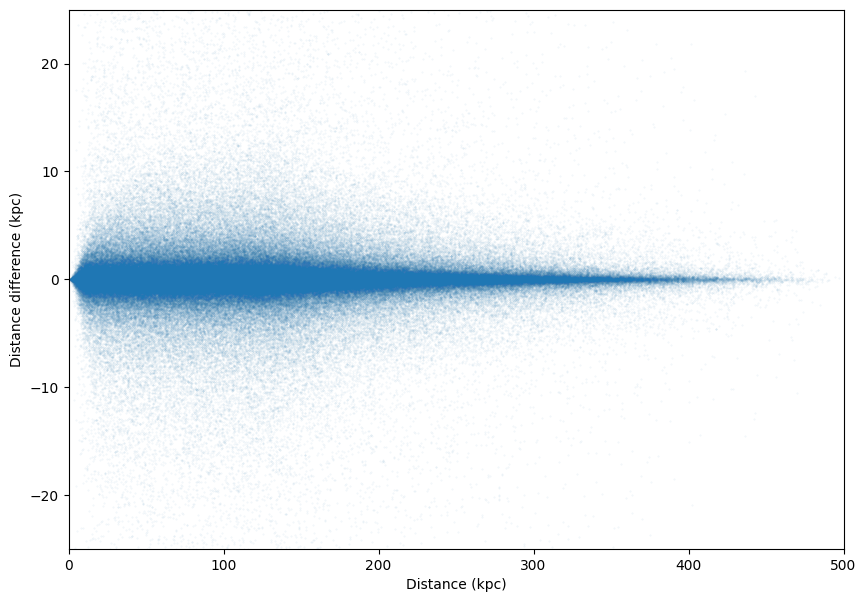

In [88]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(icrs_coord.distance,icrs_coord.distance.value - Darr*u.m.to(u.kpc), s= 0.1, alpha = 0.1)
ax.set_ylim(-25, 25)
ax.set_xlim(0, 500)
ax.set_ylabel('Distance difference (kpc)')
ax.set_xlabel('Distance (kpc)')
plt.show()

Good, it kind of works with the known Vz, now we have to test if the interpolator gives the correct Vz or a new correction is needed. 

In [159]:
from scipy.interpolate import RegularGridInterpolator
import pickle

with open('/Users/mncavieres/Documents/2024-2/HVS/Data/vz_interpolator/vz_rf_vr_sergey.pkl', 'rb') as f:
#with open('/Users/mncavieres/Documents/2024-2/HVS/Data/vz_interpolator/vz_rf_vr_sergey_extrapolate.pkl', 'rb') as f:
    interpolator_vz = pickle.load(f)

In [48]:


# get the galactocentric distance
R_gc = (data['x']**2 + data['y']**2 + data['z']**2)**0.5

# interpolate to get vz/r*vr
logR = np.log10(R_gc)
ratios = data['z']/R_gc # Vz/R*VR
points = np.array([logR, ratios]).T  # Combine logR and z/R_gc into a single array

vz_rvr = interpolator_vz(points) # Vzf/Rf*
#vz_rvr = interpolator_vz(logR, z/R_gc)

V_r_sergey = data['vx']* R_gc/data['x'] #VR = orbit.v_x * R / orbit.x, this corresponds to a non-orthogonal decomposition of the velocity in radial and vz components
vz = vz_rvr * V_r_sergey/R_gc
vz = vz * 1000 # convert to m/s


In [49]:
vz

nan
-139449531.95391467
nan
-146135.38827602184
-314301.4176515542
-1010853.9273293456
-657644.3674138506
-39289.42627466706
nan
nan
-328791.42374121404


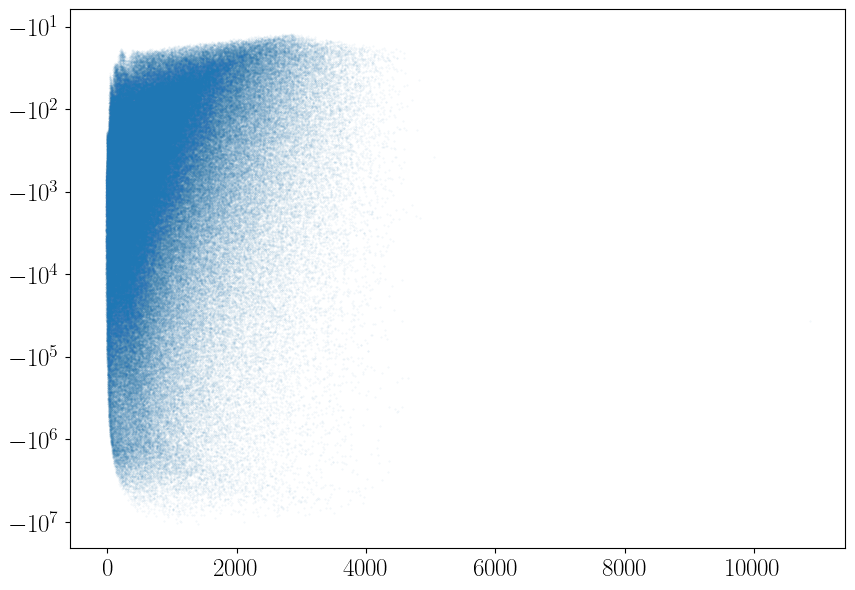

In [49]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(data['vz'], vz/1000, s= 0.1, alpha = 0.1)
ax.set_yscale('symlog')
plt.show()

# Focus on a single source

In [89]:
source_id = 125
ra_rad = icrs_coord.ra.rad[source_id:source_id+1]
dec_rad = icrs_coord.dec.rad[source_id:source_id+1]
pmra_rad_s = icrs_coord.pm_ra_cosdec.to(u.rad/u.s).value[source_id:source_id+1]
pmdec_rad_s = icrs_coord.pm_dec.to(u.rad/u.s).value[source_id:source_id+1]
vz = data['vz'][source_id:source_id+1]
l = data['l'][source_id:source_id+1]
b = data['b'][source_id:source_id+1]
dist = icrs_coord.distance[source_id:source_id+1]


In [102]:
# decompose vz

vz_decomp = data['vz'] - data['z']*data['vx']/data['x']

In [103]:
VGCR, VR, Darr =  getdist_corrected(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, vz_decomp[source_id:source_id+1], l, b)

In [104]:
Darr*u.m.to(u.kpc)

array([46.86368579])

In [105]:
dist

<Distance [46.35382748] kpc>

In [106]:

# get the galactocentric distance
R_gc = (data['x']**2 + data['y']**2 + data['z']**2)**0.5

# interpolate to get vz/r*vr
logR = np.log10(R_gc)
ratios = data['z']/R_gc # Vzf/Rf*VRf
points = np.array([logR, ratios]).T  # Combine logR and z/R_gc into a single array


In [34]:
vz_rvr = interpolator_vz(points[source_id]) # Vzf/Rf*VRf, where VR = sqrt(vx^2 + vy^2) * R / sqrt(x^2 + y^2)
#vz_rvr = interpolator_vz(logR, z/R_gc)

V_r_sergey = R_gc*((data['vx']**2 + data['vy']**2)**0.5)/(data['x']**2 + data['y']**2)**0.5       #data['vx']* R_gc/data['x'] #VR = orbit.v_x * R / orbit.x, this corresponds to a non-orthogonal decomposition of the velocity in radial and vz components
vz = vz_rvr*V_r_sergey/ V_r_sergey
vz = vz * 1000 # convert to m/s

NameError: name 'interpolator_vz' is not defined

In [95]:
points[source_id]

array([ 1.66982127, -0.91638592])

In [97]:
interpolator_vz(points[source_id])

array([nan])

In [ ]:
vz_decomp = v

# No speedy star, just Gala ejections

In [157]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import sys
import os

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) *0.001* auni.kpc
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 10000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x # this is some decomposition of the velocity in a weird way vxR/x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms), orbit.x.to_value(auni.kpc), orbit.y.to_value(auni.kpc), orbit.z.to_value(auni.kpc), orbit.v_x.to_value(kms), orbit.v_y.to_value(kms), orbit.v_z.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 3.5, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 100
    r1, r2, r3, r4, c1, c2, c3, v1, v2, v3 = [], [], [], [], [], [], [], [], [], []
    for curv, curc in tqdm(zip(vej, cosa), total=N):
        R, z, VR, Vz, x, y, z, vx, vy, vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)
        c1.append(x)
        c2.append(y)
        c3.append(z)
        v1.append(vx)
        v2.append(vy)
        v3.append(vz)
    

    return [np.array(_) for _ in [r1, r2, r3, r4, c1, c2, c3, v1, v2, v3]]

print('Starting')
# Do the simulation
R, z, VR, Vz, x, y, z, vx, vy, vz = doall(10000, 3)

Starting


 22%|██▏       | 2208/10000 [01:46<06:16, 20.68it/s]


KeyboardInterrupt: 

In [152]:
import pandas as pd

In [136]:
# save orbits
#gala_orbits_small = pd.DataFrame({'R': R.flatten, 'z': z, 'VR': VR, 'Vz': Vz, 'x': x, 'y': y, 'z': z, 'vx': vx, 'vy': vy, 'vz': vz}).to_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/orbits/gala_ejections/orbits_small.csv', index=False)

In [137]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactocentric
import astropy.units as u




coords_gala = Galactocentric(x = x*u.kpc, y = y*u.kpc, z = z*u.kpc,
                    v_x = vx*u.km/u.s, v_y = vy*u.km/u.s, v_z = vz*u.km/u.s)

icrs_coord_gala = coords_gala.transform_to(coord.ICRS())

In [138]:
source_id = 125
ra_rad = icrs_coord_gala.ra.rad.flatten()
dec_rad = icrs_coord_gala.dec.rad.flatten()
pmra_rad_s = icrs_coord_gala.pm_ra_cosdec.to(u.rad/u.s).value.flatten()
pmdec_rad_s = icrs_coord_gala.pm_dec.to(u.rad/u.s).value.flatten()
#vz = data['vz'][source_id:source_id+1]
# make l and b just zeros
l = np.zeros_like(ra_rad.flatten())#data['l'][source_id:source_id+1]
b = np.zeros_like(ra_rad.flatten()) #data['b'][source_id:source_id+1]
dist = icrs_coord_gala.distance.flatten()

In [139]:
VGCR_new, VR_new, Darr =  getdist_corrected(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, Vz.flatten(),l , b)

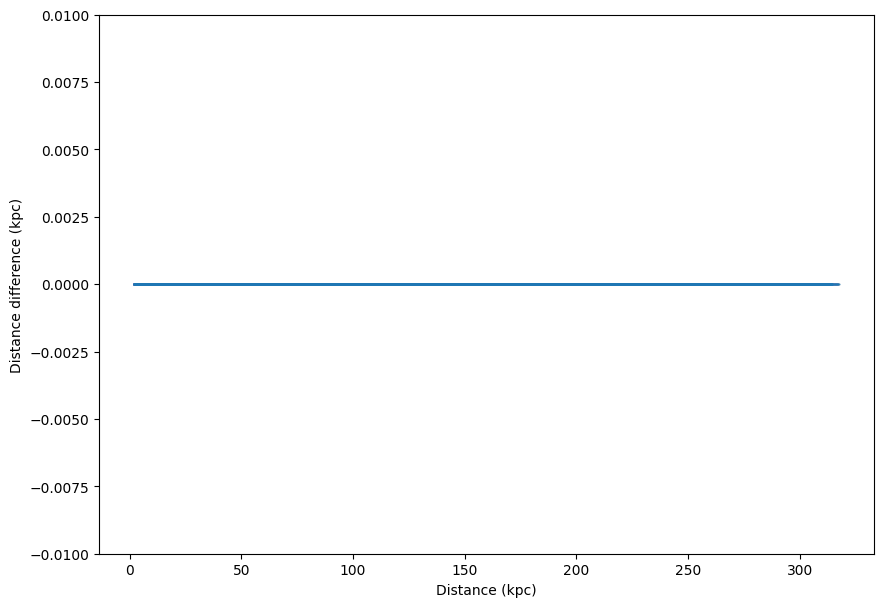

In [140]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(dist, dist.value- Darr*u.m.to(u.kpc), s= 0.1, alpha = 0.1)
ax.set_ylim(-0.01, 0.01)
ax.set_ylabel('Distance difference (kpc)')
ax.set_xlabel('Distance (kpc)')
plt.show()

# Now using the interpolator

In [160]:
# compute Vz from the interpolator

# get the galactocentric distance
R_gc = ((x**2 + y**2 + z**2)**0.5).flatten()

# interpolate to get vz/r*vr
logR = np.log10(R_gc)
ratios = z.flatten()/R_gc # Vzf/Rf*VRf
points = np.array([logR, ratios]).T  # Combine logR and z/R_gc into a single array


In [161]:
vz_rvr = interpolator_vz(points) # Vzf/Rf*VRf, where VR = sqrt(vx^2 + vy^2) * R / sqrt(x^2 + y^2)
#vz_rvr = interpolator_vz(logR, z/R_gc)

V_r_sergey = R_gc*(((vx**2 + vy**2)**0.5)/(x**2 + y**2)**0.5  ).flatten()     #data['vx']* R_gc/data['x'] #VR = orbit.v_x * R / orbit.x, this corresponds to a non-orthogonal decomposition of the velocity in radial and vz components
vz_interpolated = vz_rvr*R_gc/ V_r_sergey.flatten()
#vz = vz * 1000 # convert to m/s

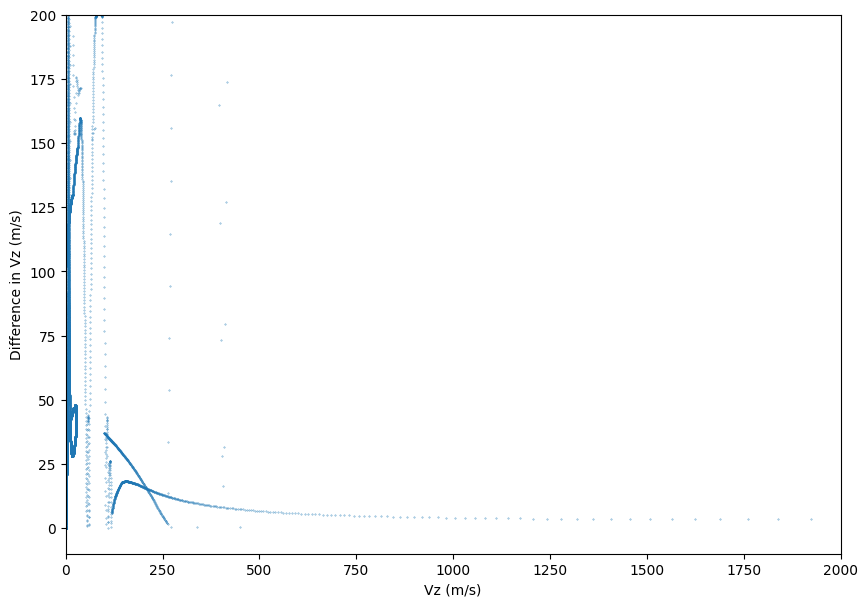

In [167]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(Vz.flatten(), np.abs(vz_interpolated - Vz.flatten()/1000) , s= 0.1, alpha = 0.8)
ax.set_ylim(-10, 200)
#ax.plot([-2000, 2000], [0, 0], 'k--', alpha = 0.6)
ax.set_xlim(0, 2000)
#ax.set_yscale('symlog') 
ax.set_ylabel('Difference in Vz (m/s)')
ax.set_xlabel('Vz (m/s)')
plt.show()

In [165]:
# save the orbits to a file
#data_gala_orbits = pd.DataFrame({'R': R.flatten(), 'z': z.flatten(), 'VR': VR.flatten(), 'Vz': Vz.flatten(), 'x': x.flatten(), 'y': y.flatten(), 'z': z.flatten(), 'vx': vx.flatten(), 'vy': vy.flatten(), 'vz': vz.flatten(), 'vz_interp': vz_interpolated.flatten()}).to_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/orbits/gala_ejections/orbits_small.csv', index=False)

KeyboardInterrupt: 

# Test different interpolators

In [153]:
from scipy.stats import binned_statistic_2d

xbins = 100  # bins in z/R
ybins = 100  # bins in log10(VR)

stat, xedges, yedges, binnum = binned_statistic_2d(
    y= z.flatten()/R.flatten(), # to avoid log(0) we add a small number
    x=np.log10(R.flatten()),
    values=Vz.flatten()/R.flatten()*VR.flatten(),
    statistic='mean',
    bins=[xbins, ybins]
)


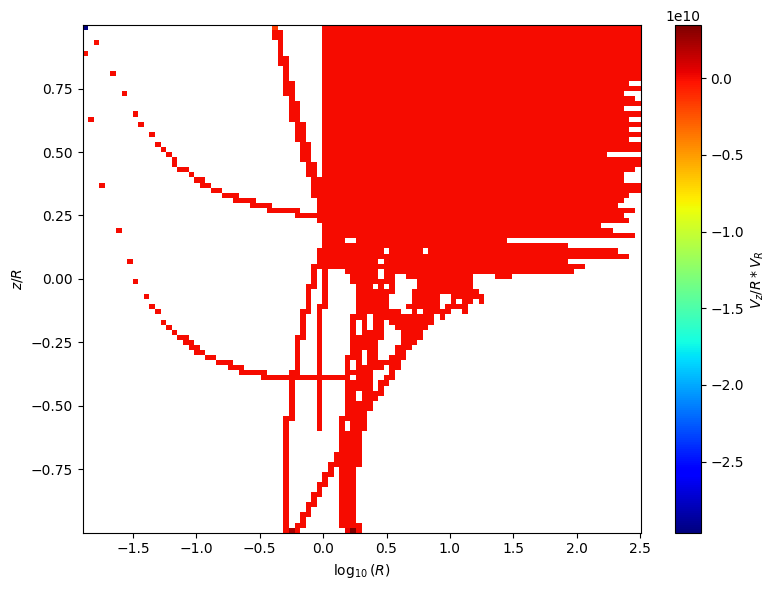

In [154]:
# Plot the 2D statistic 
plt.figure(figsize=(8, 6))
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')

cb = plt.colorbar()
cb.set_label(r'$V_z/R*V_R$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$z/R$')
plt.tight_layout()
#plt.savefig('/Users/mncavieres/Documents/2024-2/HVS/Plots/interpolator/vz_rf_log10R_sergey.pdf', dpi = 300)
plt.show()

In [ ]:
Vz.flatten()/R.flatten()*VR.flatten(),